In [1]:
import yfinance as yahoo
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
commodities = ['GOLD','HMY','AUY','VALE','TX','TEN','X','AGRO','PBR','OGZPY','XOM','TOT']

In [3]:
df = yahoo.download(commodities,period="1y",interval="60m")['Adj Close'].fillna(method='ffill')
df = df.fillna(method='ffill')
start, end = df.iloc[0,:], df.iloc[-1,:]
renta = (end / start)
renta = renta.sort_values(axis=0,ascending=False)
renta

[*********************100%***********************]  12 of 12 completed


HMY      1.998992
AUY      1.750000
GOLD     1.489244
TEN      1.085129
VALE     1.032817
TX       1.020784
AGRO     0.903915
TOT      0.821147
OGZPY    0.770864
X        0.703436
PBR      0.645210
XOM      0.641764
dtype: float64

In [4]:
df

,AGRO,AUY,GOLD,HMY,OGZPY,PBR,TEN,TOT,TX,VALE,X,XOM
Datetime,,,,,,,,,,,,
2019-08-15 09:30:00-04:00,5.620,3.360,18.129999,2.9765,6.830,13.360,9.2800,48.139999,16.840000,10.970,11.060,67.330002
2019-08-15 10:30:00-04:00,5.720,3.390,18.059999,3.0100,6.822,13.340,9.2450,48.220001,16.785000,10.985,11.050,67.459999
2019-08-15 11:30:00-04:00,5.785,3.410,18.190001,3.0300,6.830,13.385,9.0500,48.209999,16.719999,10.945,11.015,67.260101
2019-08-15 12:30:00-04:00,5.750,3.430,18.270000,3.0200,6.830,13.330,9.0350,48.080002,16.629999,10.910,11.000,67.025002
2019-08-15 13:30:00-04:00,5.785,3.450,18.290001,3.0000,6.820,13.165,9.0149,47.939999,16.600000,10.750,10.905,66.955002
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-14 11:30:00-04:00,5.060,5.837,26.650000,5.7900,5.245,8.680,9.9800,39.459999,17.170000,11.290,7.825,43.070000
2020-08-14 12:30:00-04:00,5.040,5.855,26.789000,5.8200,5.240,8.645,10.2200,39.529999,17.215000,11.310,7.815,43.189899
2020-08-14 13:30:00-04:00,5.190,5.880,26.875000,5.8750,5.240,8.650,10.1999,39.605900,17.240000,11.280,7.855,43.160000


In [5]:
noa = len(df.columns) #number of assets
weights = np.random.random(noa)
weights /= np.sum(weights)
observations = len(df.index)
alpha = 0.05
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()

In [6]:
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, observations):
    portfolio_return = np.sum(mean_returns * weights) * observations
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(observations)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, observations):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, observations)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-0.3,0.3)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [7]:
min_port_VaR = min_VaR(mean_returns, cov, alpha, observations)

minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,3) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

HMY      0.296
GOLD     0.294
AUY      0.294
TX       0.212
TEN      0.157
AGRO     0.138
VALE     0.110
OGZPY    0.080
TOT      0.018
XOM     -0.109
X       -0.234
PBR     -0.256
Name: weigths, dtype: float64

In [8]:
portfolio = (df * minimal_VaR.weigths).T.sum()

retorno = portfolio.pct_change().cumsum()

benchmark = df.T.mean() # build an equally weigthed portfolio to use as benchmark

assets_return = df.pct_change().cumsum() # spectrum of the assets returns


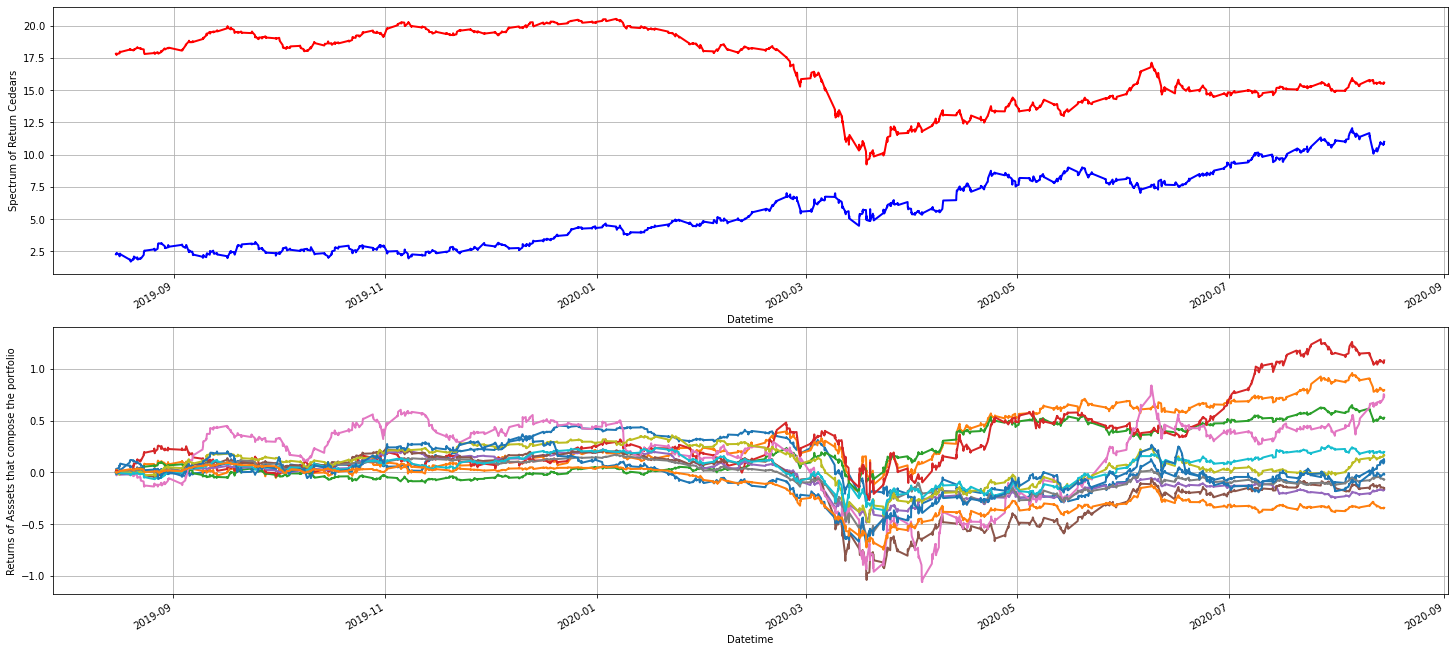

In [9]:
fig = plt.figure(figsize=(25,12))
ax1 = fig.add_subplot(211, ylabel='Spectrum of Return Cedears')
portfolio.plot(ax=ax1, color='b', lw=2.)
benchmark.plot(ax=ax1, color='r', lw=2.)
ax1.grid()
ax2 = fig.add_subplot(212, ylabel='Returns of Asssets that compose the portfolio')
assets_return.plot(ax=ax2, lw=2., legend=False)
ax2.grid()
plt.show()

In [10]:
portfolio, benchmark

(Datetime
 2019-08-15 09:30:00-04:00     2.274154
 2019-08-15 10:30:00-04:00     2.264695
 2019-08-15 11:30:00-04:00     2.293809
 2019-08-15 12:30:00-04:00     2.331010
 2019-08-15 13:30:00-04:00     2.383345
                                ...    
 2020-08-14 11:30:00-04:00    10.794218
 2020-08-14 12:30:00-04:00    10.895007
 2020-08-14 13:30:00-04:00    10.957451
 2020-08-14 14:30:00-04:00    10.960080
 2020-08-14 15:30:00-04:00    10.996140
 Length: 1767, dtype: float64,
 Datetime
 2019-08-15 09:30:00-04:00    17.824708
 2019-08-15 10:30:00-04:00    17.840583
 2019-08-15 11:30:00-04:00    17.819175
 2019-08-15 12:30:00-04:00    17.775834
 2019-08-15 13:30:00-04:00    17.722908
                                ...    
 2020-08-14 11:30:00-04:00    15.504750
 2020-08-14 12:30:00-04:00    15.555742
 2020-08-14 13:30:00-04:00    15.587567
 2020-08-14 14:30:00-04:00    15.533750
 2020-08-14 15:30:00-04:00    15.575416
 Length: 1767, dtype: float64)

In [11]:
minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

HMY      0.30
GOLD     0.29
AUY      0.29
TX       0.21
TEN      0.16
AGRO     0.14
VALE     0.11
OGZPY    0.08
TOT      0.02
XOM     -0.11
X       -0.23
PBR     -0.26
Name: weigths, dtype: float64

In [12]:
portfolio = (df * minimal_VaR.weigths).T.sum()
portfolio

Datetime
2019-08-15 09:30:00-04:00     2.225250
2019-08-15 10:30:00-04:00     2.216360
2019-08-15 11:30:00-04:00     2.244489
2019-08-15 12:30:00-04:00     2.281450
2019-08-15 13:30:00-04:00     2.333684
                               ...    
2020-08-14 11:30:00-04:00    10.725580
2020-08-14 12:30:00-04:00    10.826571
2020-08-14 13:30:00-04:00    10.889302
2020-08-14 14:30:00-04:00    10.891200
2020-08-14 15:30:00-04:00    10.926900
Length: 1767, dtype: float64

In [13]:
data = df

# Calculate the returns of instruments, statistics & correlation
returns = (data - data.shift(1))/ data.shift(1)# get the returns for every serie

statistics = returns.describe().T

statistics['mad'] = returns.mad()

statistics['skew'] = returns.skew()

statistics['kurtosis'] = returns.kurtosis()

statistics = statistics.T

correlation = returns.corr() # correlation

covariance = returns.cov()  # covariance

# Calculate the deltas of the instruments as the weights assigned multiplied by their correlations (elasticity)
instruments = pd.DataFrame(index= data.columns)
instruments['weigths'] = 1/len(instruments.index) # secure allocation is equal 1
instruments['deltas'] = (instruments.weigths * correlation).sum() # deltas as elasticity of the assets
instruments['Stdev'] = returns.std()
instruments['stress'] = (instruments.deltas * instruments.Stdev) * 3 # stress applied at 4 deviations
instruments['portfolio_stress'] = instruments.stress.sum() # the stress of the portfolio

# Optional, if all the worst events happen at once, must detect the worst deviation of the instruments and apply it simultaneously
poe = (returns / returns.std()).min()
fullstress = sum(instruments.stress.multiply(poe))


In [14]:
instruments

,weigths,deltas,Stdev,stress,portfolio_stress
AGRO,0.083333,0.419983,0.015136,0.019071,0.243074
AUY,0.083333,0.313326,0.016348,0.015366,0.243074
GOLD,0.083333,0.312061,0.012118,0.011345,0.243074
HMY,0.083333,0.329062,0.020950,0.020681,0.243074
OGZPY,0.083333,0.495983,0.010161,0.015119,0.243074
PBR,0.083333,0.556242,0.017612,0.029389,0.243074
TEN,0.083333,0.382894,0.027371,0.031440,0.243074
TOT,0.083333,0.532070,0.011995,0.019146,0.243074
TX,0.083333,0.473043,0.012773,0.018126,0.243074
VALE,0.083333,0.536939,0.013599,0.021905,0.243074


In [15]:
poe, fullstress

(AGRO    -11.972863
 AUY      -9.629645
 GOLD     -7.226686
 HMY      -9.599025
 OGZPY   -13.931813
 PBR     -13.371099
 TEN      -6.845050
 TOT     -11.830001
 TX       -7.436162
 VALE    -12.508437
 X        -7.923868
 XOM      -7.618633
 dtype: float64,
 -2.4345744074239453)

In [16]:
portfolio = data.T.mean()
portfolio

Datetime
2019-08-15 09:30:00-04:00    17.824708
2019-08-15 10:30:00-04:00    17.840583
2019-08-15 11:30:00-04:00    17.819175
2019-08-15 12:30:00-04:00    17.775834
2019-08-15 13:30:00-04:00    17.722908
                               ...    
2020-08-14 11:30:00-04:00    15.504750
2020-08-14 12:30:00-04:00    15.555742
2020-08-14 13:30:00-04:00    15.587567
2020-08-14 14:30:00-04:00    15.533750
2020-08-14 15:30:00-04:00    15.575416
Length: 1767, dtype: float64

In [17]:
portfolio_returns = (portfolio - portfolio.shift(1))/ portfolio.shift(1)

portfolio_stats = portfolio_returns.describe(percentiles=[.01,.05,.10]).T

portfolio_stats['var'] = portfolio_returns.var()

portfolio_stats['skew'] = portfolio_returns.skew()

portfolio_stats['Kurtosis'] = portfolio_returns.kurtosis()

In [18]:
risk = pd.DataFrame(index=data.columns)
risk['numerator'] = (instruments.deltas.multiply(covariance)).sum()
risk['denominator'] = portfolio_returns.std() * (-2.32635) # at 1% of inverse normal dist.
risk['GradVaR'] = -risk.numerator / risk.denominator
risk['CVaRj'] = risk.GradVaR * instruments.deltas # Component VaR of the Risk Factors j
risk['thetai'] = (risk.CVaRj * correlation).sum() # Theta i of the instruments
risk['CVaRi'] = risk.thetai * (1/len(data.columns)) # Component VaR of the Instruments i
risk['totalCVaRi'] = risk.CVaRi.sum() #total CVaR of the portfolio
risk['CVaRattribution'] = risk.CVaRi / risk.totalCVaRi # risk allocation by instrument in the portfolio
risk

,numerator,denominator,GradVaR,CVaRj,thetai,CVaRi,totalCVaRi,CVaRattribution
AGRO,0.000490,-0.022155,0.022133,0.009296,0.046848,0.003904,0.066398,0.058797
AUY,0.000296,-0.022155,0.013356,0.004185,0.015734,0.001311,0.066398,0.019747
GOLD,0.000213,-0.022155,0.009611,0.002999,0.011231,0.000936,0.066398,0.014095
HMY,0.000431,-0.022155,0.019439,0.006397,0.025259,0.002105,0.066398,0.031702
OGZPY,0.000442,-0.022155,0.019936,0.009888,0.058850,0.004904,0.066398,0.073859
PBR,0.000993,-0.022155,0.044813,0.024927,0.166383,0.013865,0.066398,0.208819
TEN,0.000814,-0.022155,0.036757,0.014074,0.064666,0.005389,0.066398,0.081160
TOT,0.000613,-0.022155,0.027668,0.014721,0.093992,0.007833,0.066398,0.117965
TX,0.000517,-0.022155,0.023349,0.011045,0.062698,0.005225,0.066398,0.078689
VALE,0.000707,-0.022155,0.031892,0.017124,0.110333,0.009194,0.066398,0.138474


In [19]:
cartera = pd.DataFrame(index=data.columns)
cartera['base'] = instruments.weigths
cartera['CVaRattribution'] = risk.CVaRattribution.sort_values(axis=0,ascending=False)
cartera['new'] = minimal_VaR.weigths
cartera['condition'] = (cartera.base  * cartera.CVaRattribution)
cartera['newrisk'] = (cartera.new  * cartera.CVaRattribution)
cartera['differences'] = (cartera.newrisk - cartera.condition)  # apply this result as a percentage to multiply new weights
cartera['adjustments'] = (cartera.newrisk - cartera.condition) / cartera.condition #ALARM if its negative sum up the difference, 
                                            #if it is positive rest it, you need to have 0
cartera['suggested'] = cartera.new * (1 + cartera.adjustments)   
cartera['tototal'] = cartera.suggested.sum()
cartera['MinCVaR'] = cartera.suggested / cartera.tototal
cartera

,base,CVaRattribution,new,condition,newrisk,differences,adjustments,suggested,tototal,MinCVaR
AGRO,0.083333,0.058797,0.14,0.004900,0.008232,0.003332,0.68,0.2352,5.988,0.039279
AUY,0.083333,0.019747,0.29,0.001646,0.005727,0.004081,2.48,1.0092,5.988,0.168537
GOLD,0.083333,0.014095,0.29,0.001175,0.004088,0.002913,2.48,1.0092,5.988,0.168537
HMY,0.083333,0.031702,0.30,0.002642,0.009511,0.006869,2.60,1.0800,5.988,0.180361
OGZPY,0.083333,0.073859,0.08,0.006155,0.005909,-0.000246,-0.04,0.0768,5.988,0.012826
PBR,0.083333,0.208819,-0.26,0.017402,-0.054293,-0.071695,-4.12,0.8112,5.988,0.135471
TEN,0.083333,0.081160,0.16,0.006763,0.012986,0.006222,0.92,0.3072,5.988,0.051303
TOT,0.083333,0.117965,0.02,0.009830,0.002359,-0.007471,-0.76,0.0048,5.988,0.000802
TX,0.083333,0.078689,0.21,0.006557,0.016525,0.009967,1.52,0.5292,5.988,0.088377
VALE,0.083333,0.138474,0.11,0.011539,0.015232,0.003693,0.32,0.1452,5.988,0.024248


In [20]:
propuesta = data * cartera.MinCVaR
propuesta = propuesta.T.sum()

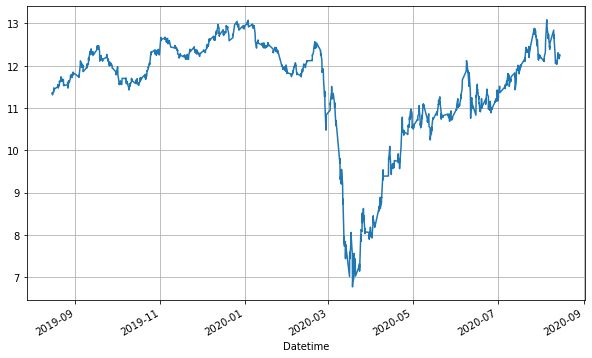

In [21]:
p = propuesta.plot(figsize=(10,6))
p.grid()

In [22]:
propuesta

Datetime
2019-08-15 09:30:00-04:00    11.351034
2019-08-15 10:30:00-04:00    11.347314
2019-08-15 11:30:00-04:00    11.359670
2019-08-15 12:30:00-04:00    11.348927
2019-08-15 13:30:00-04:00    11.311512
                               ...    
2020-08-14 11:30:00-04:00    12.170213
2020-08-14 12:30:00-04:00    12.215171
2020-08-14 13:30:00-04:00    12.254394
2020-08-14 14:30:00-04:00    12.221301
2020-08-14 15:30:00-04:00    12.264255
Length: 1767, dtype: float64

In [23]:
ponderaciones = cartera.MinCVaR.sort_values(axis=0,ascending=False)
ponderaciones.head(10)

HMY     0.180361
GOLD    0.168537
AUY     0.168537
PBR     0.135471
X       0.106012
TX      0.088377
TEN     0.051303
AGRO    0.039279
XOM     0.024248
VALE    0.024248
Name: MinCVaR, dtype: float64